In [1]:
import numpy
from matplotlib import pyplot, animation
from IPython.display import HTML
%matplotlib inline

In [2]:
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [4]:
def rho_red_light(x,rho_max):
    rho = rho_max * numpy.ones_like(x)
    mask = numpy.where(x < 3.0)
    rho[mask] = 0.5 * rho_max
    return rho
def flux(rho, u_max, rho_max):
    F = rho * u_max * (1.0 - rho / rho_max)
    return F

In [6]:
nx = 100
L = 4.0
dx = L / nx
nt = 30
rho_max = 10.0
u_max = 1.0

#x_i is now the center of the i-th cell
x = numpy.linspace(0.0 + 0.5 * dx, L - 0.5 * dx, num=nx)

rho0 = rho_red_light(x, rho_max)

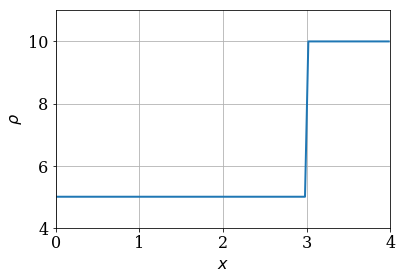

In [8]:
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\rho$')
pyplot.grid()
line = pyplot.plot(x, rho0, color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(0.0, L)
pyplot.ylim(4.0, 11.0)
pyplot.tight_layout;

In [20]:
def godunov(rho0, nt, dt, dx, bc_values, *args):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        rhoL = rho[:-1]
        rhoR = rho[1:]
        F = 0.5 * (flux(rhoL, *args) + flux(rhoR, *args) - dx / dt * (rhoR - rhoL))
        #advance in time
        rho[1:-1] = rho[1:-1] - dt / dx * (F[1:] - F[:-1])
        #Apply BC
        rho[0], rho[-1] = bc_values
        #Record time-step solution
        rho_hist.append(rho.copy())
    return rho_hist

In [22]:
sigma = 1.0
dt = sigma * dx / u_max
rho_hist = godunov(rho0, nt, dt, dx, (rho0[0], rho0[-1]), u_max, rho_max)

In [25]:
def update_plot(n, rho_hist):
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(rho_hist[n])


In [26]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())

In [16]:
def minmod(e, dx):
    sigma = numpy.zeros_like(e)
    for i in range(1, len(e) - 1):
        de_minus = (e[i] - e[i-1]) / dx
        de_plus = (e[i+1] - e[i]) / dx
        if de_minus > 0 and de_plus > 0:
            sigma[i] = min(de_minus, de_plus)
        elif de_minus < 0 and de_plus < 0:
            sigma[i] = max(de_minus, de_plus)
        else:
            sigma[i] = 0.0
    return sigma

In [29]:
def muscl(rho0, nt, dt, dx, bc_values, *args):
    def compute_flux(rho):
        sigma = minmod(rho, dx)
        rhoL = (rho + sigma * dx / 2.0)[:-1]
        rhoR = (rho - sigma * dx / 2.0)[1:]
        F = 0.5 * (flux(rhoL, *args) + flux(rhoR, *args) - dx / dt * (rhoR - rhoL))
        return F
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    rho_star = rho0.copy()
    for n in range(nt):
        F = compute_flux(rho)
        rho_star[1:-1] = rho[1:-1] - dt / dx * (F[1:] - F[:-1])
        rho_star[0], rho_star[-1] = bc_values
        F = compute_flux(rho_star)
        rho[1:-1] = 0.5 * (rho[1:-1] + rho_star[1:-1] - dt / dx * (F[1:] - F[:-1]))
        rho[0], rho[-1] = bc_values
        rho_hist.append(rho.copy())
    return rho_hist

In [32]:
sigma = 1.0
dt = sigma * dx / u_max

rho_hist = muscl(rho0, nt, dt, dx, (rho0[0], rho0[-1]), u_max, rho_max)

In [33]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())